In [1]:
from scipy.ndimage import gaussian_filter
from skimage.morphology import remove_small_objects
from skimage.measure import label
import matplotlib.pyplot as plt
from tifffile import imread
import cv2
import numpy as np
from scipy import stats

In [2]:
def get_mask(im):
    threshold = 200 # threshold for green channel

    mask = (im[:,:,1] > threshold).astype(float)
    blurred = gaussian_filter(mask, sigma=2)
    mask = blurred < 0.70

    cc_threshold = 100000 # connected components threshold size (keep above)
    mask = remove_small_objects(mask, min_size=cc_threshold)

    labeled_mask = label(mask, connectivity=2)
    return labeled_mask

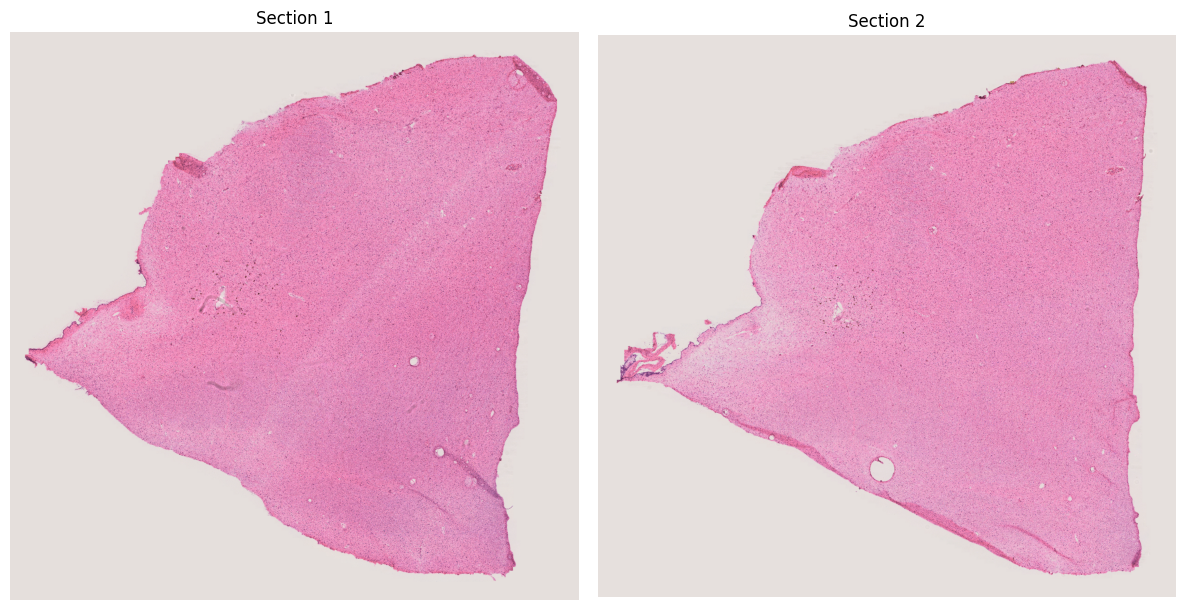

In [3]:
im1_pth = 'test_data/cropped_sections/crop_0.tif'
im2_pth = 'test_data/cropped_sections/crop_1.tif'

# Read images
im1 = imread(im1_pth)
im2 = imread(im2_pth)

# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display first image
axes[0].imshow(im1)
axes[0].axis('off')
axes[0].set_title('Section 1')

# Display second image
axes[1].imshow(im2)
axes[1].axis('off')
axes[1].set_title('Section 2')

plt.tight_layout()
plt.show()

In [4]:
im1_mask = get_mask(im1)
im2_mask = get_mask(im2)

ds = 8

im1_mask_ds = im1_mask[::ds, ::ds]
im2_mask_ds = im2_mask[::ds, ::ds]

In [5]:
# initialize the affine matrix to identity
warp_matrix = np.eye(2, 3, dtype=np.float32)

# set the stopping criteria: max 5000 iterations OR epsilon of 1e-7
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000, 1e-7)

# run the ECC algorithm. This returns the final correlation and updates warp_matrix
cc, warp_matrix = cv2.findTransformECC(
    templateImage = im1_mask_ds.astype(np.float32),
    inputImage    = im2_mask_ds.astype(np.float32),
    warpMatrix    = warp_matrix,
    motionType    = cv2.MOTION_AFFINE,
    criteria      = criteria,
    inputMask     = None,
    gaussFiltSize = 1
)

print("Estimated affine matrix (2×3):\n", warp_matrix)

Estimated affine matrix (2×3):
 [[ 0.9562261   0.08635351  3.3595378 ]
 [-0.03846566  0.9434627   9.754477  ]]


In [6]:
# 1) compute per‐channel modes (R, G, B)
modes = []
for c in range(3):
    vals = im2[..., c].ravel().astype(np.int64)
    uniq, counts = np.unique(vals, return_counts=True)
    modes.append(int(uniq[np.argmax(counts)]))
# modes is [mode_R, mode_G, mode_B]

# 2) build BGR tuple for borderValue
border_val = (modes[2], modes[1], modes[0])  # (mode_B, mode_G, mode_R)

In [7]:
# warp_matrix from findTransformECC on the downsampled masks
M_full = warp_matrix.copy()
M_full[0,2] *= ds
M_full[1,2] *= ds

# now warp your original im2 into im1’s frame
aligned_im2 = cv2.warpAffine(
    src   = im2,
    M     = M_full,
    dsize = (im1.shape[1], im1.shape[0]),
    flags = cv2.INTER_NEAREST | cv2.WARP_INVERSE_MAP,
    borderMode  = cv2.BORDER_CONSTANT,
    borderValue = border_val
)

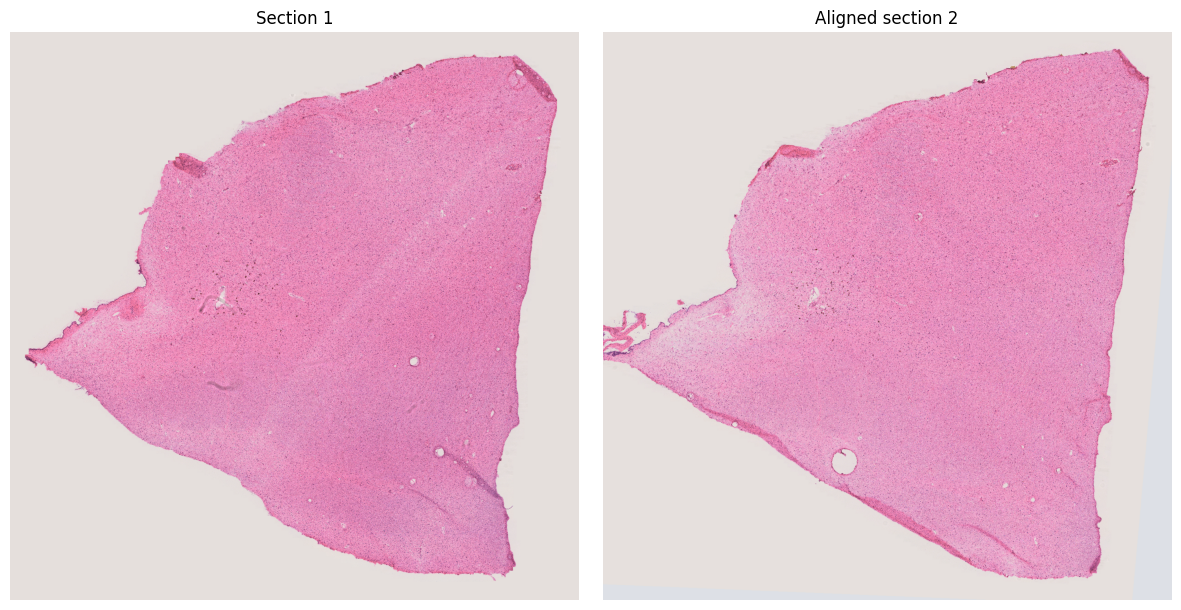

In [8]:
# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display first image
axes[0].imshow(im1)
axes[0].axis('off')
axes[0].set_title('Section 1')

# Display second image
axes[1].imshow(aligned_im2)
axes[1].axis('off')
axes[1].set_title('Aligned section 2')

plt.tight_layout()
plt.show()